In [ ]:
import numpy as np
from scipy.signal import iirdesign
from scipy.signal import filtfilt
from scipy.signal import savgol_filter


import os
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
def compute_emg_buzsakiMethod(x, y, sig1, sig2, smoothWindow):
    """
    Computes the EMG signal using the Buzsaki method.

    Parameters:
        x (float): The target sampling of the EMG.
        y (float): The sampling frequency of the data.
        sig1 (numpy.ndarray): The signal of the first channel.
        sig2 (numpy.ndarray): The signal of the second channel.
        smoothWindow (int): The smoothing window for the EMG data.
    Returns:
        dict: A dictionary containing the computed EMG signal and related data.

    Note:
        This function filters the signal in the high frequency range to remove low-frequency physiologically correlated LFPs 
        (e.g., theta, delta, SPWs, etc.). It then computes the correlation between the two signals within different windows.
    """
    binScootS = 1 / x
    binScootSamps = round(y * binScootS)

    # 2. Filter the signal in the high frequency range
    # Filter first in high frequency band to remove low-freq physiologically
    # correlated LFPs (e.g., theta, delta, SPWs, etc.)
    maxfreqband = int(min(625, y / 2))
    xcorr_freqband = [275, 300, maxfreqband - 25, maxfreqband-0.0000001]  # Hz
    filteredSig1 = filtsig_in(sig1, y, xcorr_freqband)[0]
    filteredSig2 = filtsig_in(sig2, y, xcorr_freqband)[0]

    # 3. The relevant parameters important for further correlation analysis
    xcorr_window_samps = round(binScootS * y)
    xcorr_window_inds = np.arange(-xcorr_window_samps, xcorr_window_samps + 1)
    timestamps = np.arange(xcorr_window_inds[-1], sig1.shape[0] - xcorr_window_inds[-1], binScootSamps)
    numbins = len(timestamps)
    EMGCorr = np.zeros(numbins)
    c1, c2 = [], []
    binind, binindstart = -1, 0

    # Loop through different windows
    for i in range(numbins):
        binind += 1
        s1 = []
        s2 = []
        for k in (timestamps[i] + xcorr_window_inds):
          s1.append(filteredSig1[k])
          s2.append(filteredSig2[k])
        c1.append(s1)
        c2.append(s2)
        binindend = binind
        tmp = np.corrcoef(c1, c2)[0, 1]
        EMGCorr[binindstart:(binindend+1)] += tmp
        c1, c2 = [], []
        binindstart = binind + 1

    EMGCorr = EMGCorr/(2 * (2 - 1) / 2)
    EMGNorm = bz_NormToRange(EMGCorr, [0, 1])

    # Making the final structure of the EMG
    EMGFromLFP = {
        'timestamps': timestamps / y,
        'data': EMGCorr,
        'Norm': EMGNorm,
        'channels': 'HPC and PFC',
        'detectorName': 'bz_EMGFromLFP',
        'samplingFrequency': x
    }

    # Smoothing the EMG data
    dtEMG = 1 / EMGFromLFP['samplingFrequency']
    EMGFromLFP['smoothed'] = savgol_filter(EMGFromLFP['data'], window_length=smoothWindow, polyorder=4)

    # Saving the data matrix
    return EMGFromLFP

def filtsig_in(sig, Fs, filtband_or_Filt):
    """
    Filters a signal using a specified filter or filter band.

    Parameters:
        sig (numpy.ndarray or list): The input signal to be filtered.
        Fs (float): The sampling frequency of the signal.
        filtband_or_Filt (list, numpy.ndarray, or tuple): The filter band or filter to be used. 
            If it's a list or numpy array, it should contain the pass and stop frequencies for the filter. 
            If it's a tuple, it should contain the filter coefficients.

    Returns:
        filt_sig (numpy.ndarray or list): The filtered signal.
        Filt (tuple): The filter used, represented as a tuple of coefficients.

    Note:
        This function uses a zero-phase digital filter to avoid phase distortion. 
        It applies the filter twice, once forward and once backwards.
    Created on Matlab by: Erik Schomburg, 2011
    """
    if isinstance(filtband_or_Filt, (list, np.ndarray)):
        b, a = iirdesign(wp=[filtband_or_Filt[1], filtband_or_Filt[2]], ws=[filtband_or_Filt[0], filtband_or_Filt[3]], gpass=1, gstop=60, fs=Fs)
        Filt = (b, a)
    else:
        Filt = filtband_or_Filt

    if sig is not None:
        if isinstance(sig, list):
            filt_sig = [filtfilt(Filt[0], Filt[1], s) for s in sig]
        elif sig.ndim > 1:
            filt_sig = np.array([filtfilt(Filt[0], Filt[1], s) for s in sig.T]).T
        else:
            filt_sig = filtfilt(Filt[0], Filt[1], sig)
    else:
        filt_sig = []

    return filt_sig, Filt

def bz_NormToRange(data, newrange):
    """
    Normalizes the input data to a specified range.

    Parameters:
        data (numpy.ndarray): The input data to be normalized.
        newrange (tuple): A tuple of two elements representing the new range (min, max) to which the data should be normalized.

    Returns:
        numpy.ndarray: The normalized data.
    """

    a, b = newrange
    x = data.copy()
    xmin, xmax = x.min(), x.max()
    return a + (x - xmin) * (b - a) / (xmax - xmin)

In [11]:
mat = scipy.io.loadmat('HPC_100_CH46.continuous.mat')
signal_HPC = mat['HPC'].squeeze()
print(signal_HPC.shape)

mat_pfc = scipy.io.loadmat("PFC_100_CH11.continuous.mat")
signal_PFC = mat_pfc["PFC"].squeeze()
print(signal_PFC.shape)

(6712704,)
(6712704,)


## EEG HPC & PFC

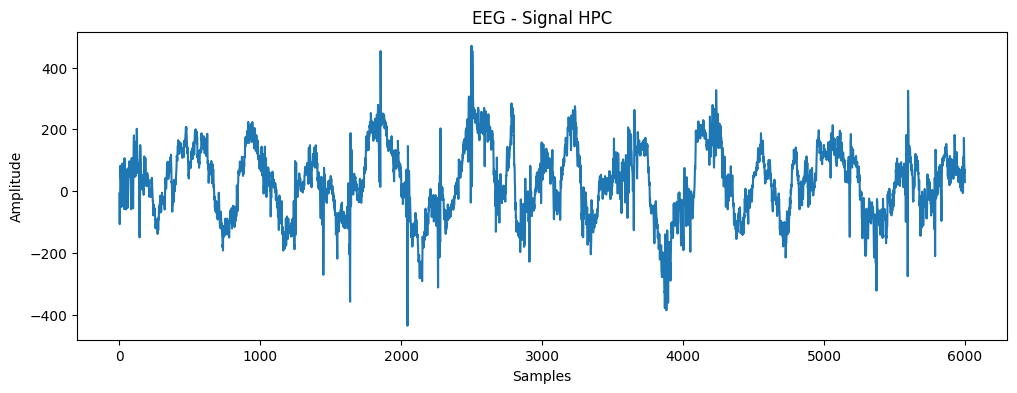

In [12]:
plt.figure(figsize=(12,4))
plt.plot(signal_HPC[:6000])   
plt.title("EEG - Signal HPC")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

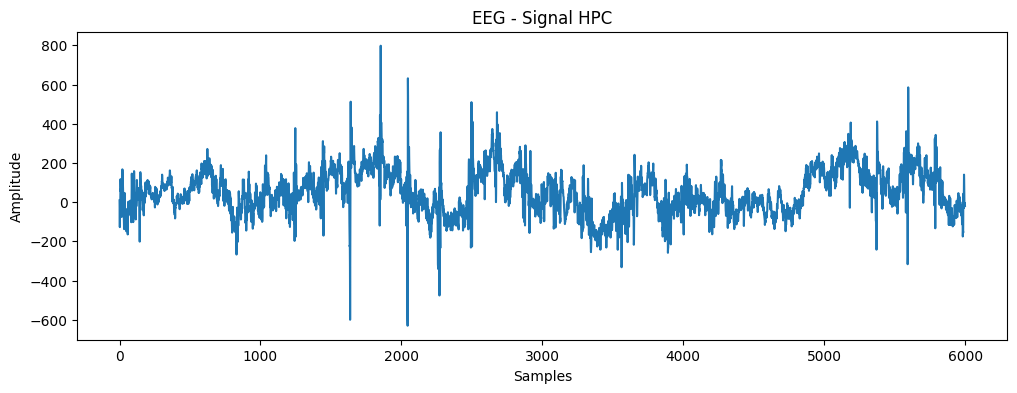

In [13]:
plt.figure(figsize=(12,4))
plt.plot(signal_PFC[:6000])   
plt.title("EEG - Signal HPC")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

## Smooth HPC & PFC

In [22]:
smooth_HPC = savgol_filter(signal_HPC, window_length=400, polyorder=3)
smooth_PFC = savgol_filter(signal_PFC, window_length=400, polyorder=3)

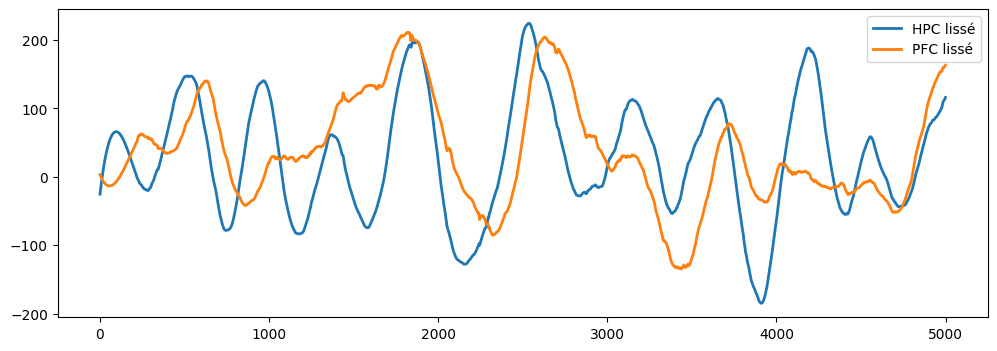

In [23]:
plt.figure(figsize=(12,4))
#plt.plot(signal_HPC[:5000], alpha=0.5, label="HPC brut")
plt.plot(smooth_HPC[:5000], label="HPC lissé", linewidth=2)
#plt.plot(signal_PFC[:5000], alpha=0.5, label="PFC brut")
plt.plot(smooth_PFC[:5000], label="PFC lissé", linewidth=2)
plt.legend()
plt.show()


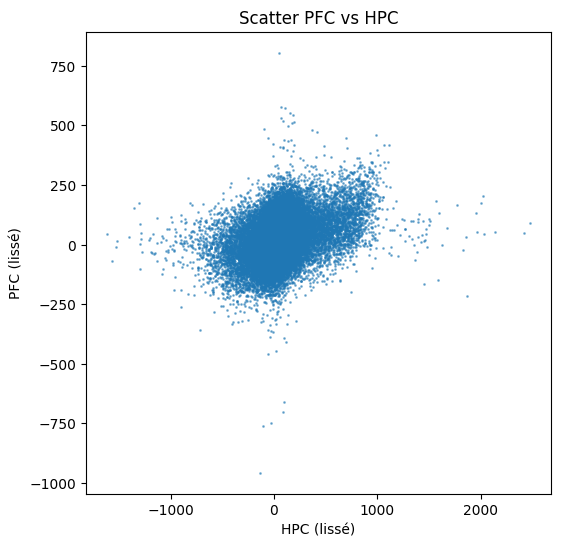

In [31]:
step = 100
plt.figure(figsize=(6,6))
plt.scatter(smooth_PFC[::step], smooth_HPC[::step], s=1, alpha=0.5)
plt.xlabel("HPC (lissé)")
plt.ylabel("PFC (lissé)")
plt.title("Scatter PFC vs HPC")
plt.show()


## EMG

In [35]:
emg_result = compute_emg_buzsakiMethod(
    x=100,             # fréquence cible du signal EMG proxy (100 Hz recommandé)
    y=1250,              # fréquence d’échantillonnage de tes données brutes
    sig1=signal_HPC,   # canal hippocampe
    sig2=signal_PFC,   # canal préfrontal
    smoothWindow=201   # fenêtre de lissage (doit être impair, 201 ≈ 160 ms)
)


#### Extract EMG

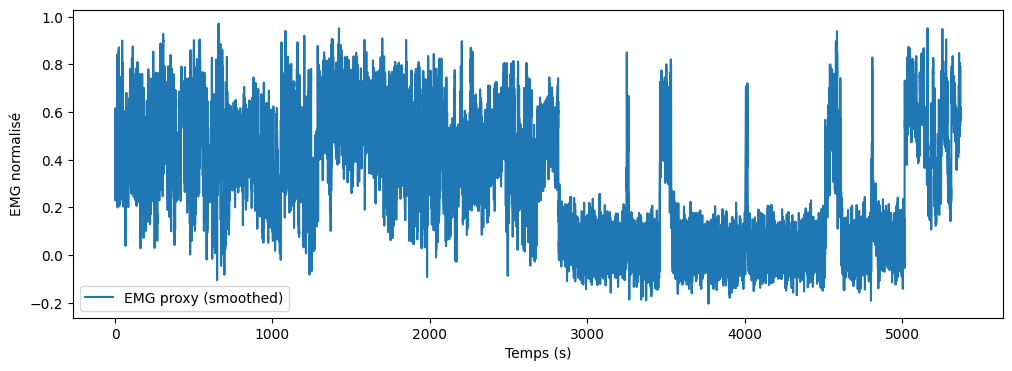

In [36]:
plt.figure(figsize=(12,4))
plt.plot(emg_result["timestamps"], emg_result["smoothed"], label="EMG proxy (smoothed)")
plt.xlabel("Temps (s)")
plt.ylabel("EMG normalisé")
plt.legend()
plt.show()
